# Chapter06 게이트가 추가된 RNN

5장에서 다룬 RNN은 순환 경로를 포함하며 과거의 정보를 기억할 수 있었다. 구조가 단순하여 구현도 쉽게 가능했었다.

하지만 안타깝게도 성능이 좋지는 못하다. 그 원인은 (많은 경우) 시계열 데이터에서 시간적으로 멀리 떨어진, $\text{장기}^{\text{long term}}$ 의존 관계를 잘 학습할 수 없다는 데 있다.

이후에는 앞 장의 단순한 RNN 대신 LSTM이나 GRU라는 계층이 주로 쓰인다. 실제로 그냥 'RNN'이라 하면 앞 장의 RNN이 아닌 LSTM을 가리키는 경우도 흔하다. 오히려 앞 장의 RNN을 명시적으로 가리킬 때 '기본(적인) RNN'이라 하기도 한다.

LSTM이나 GRU에는 '$\text{게이트}^{\text{gate}}$'라는 구조가 더해져 있는데, 이 게이트 덕분에 시계열 데이터의 장기 의존 관계를 학습 가능하다.

이번 장에서는 앞 장에서 설명한 기본 RNN의 문제를 알아보고, 이를 대신하는 계층으로써 LSTM과 GRU와 같은 '게이트가 추가된 RNN'을 소개한다.

특히 LSTM의 구조를 시간을 들여 차분하게 살펴보고, 이 구조가 '장기 기억'을 가능하게 하는 메커니즘을 이해해본다.

그리고 LSTM을 사용해서 언어 모델을 만들어, 실제로 데이털르 잘 학습하는 모습도 확인하도록 한다.

## 6.1 RNN의 문제점

앞 장에서 다룬 RNN은 시계열 데이터의 장기 의존 관계를 학습하기 어렵다. 그 원인은 BPTT에서 기울기 소실 혹은 기울기 폭발이 일어나기 때문이다.

이번 절에서는 앞에서 배운 RNN 계층을 복습하고, 뒤이어 RNN 계층이 장기 기억을 제대로 처리하지 못하는 이유를 사례를 들어 설명한다.

### 6.1.1 RNN 복습

RNN 계층은 순환 경로를 갖고 있다. 그리고 그 순환을 펼치면 다음 그림과 같이 옆으로 길게 뻗은 신경망이 만들어진다.

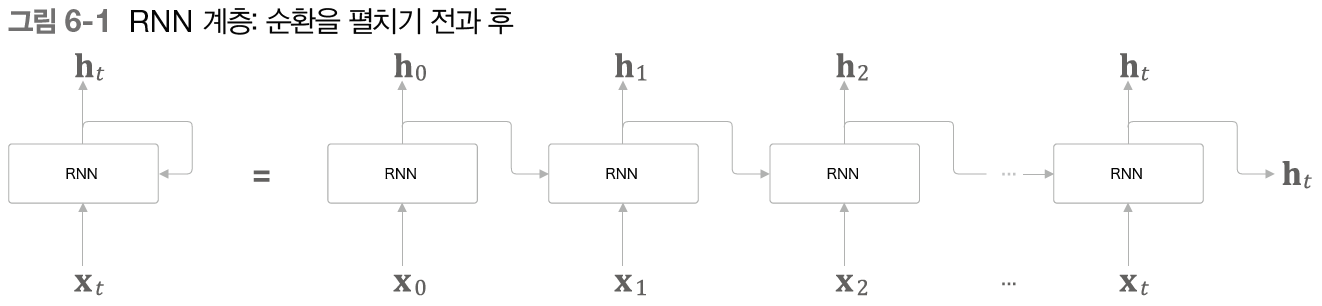

In [1]:
import os
from PIL import Image

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
img_path = os.path.join(parent_dir, 'images')

Image.open(os.path.join(img_path, 'fig 6-1.png'))

[그림 6-1]에서 보듯, RNN 계층은 시계열 데이터인 $\mathbf{x}_t$ 를 입력하면 $\mathbf{h}_t$ 를 출력한다. 이 $\mathbf{h}_t$ 는 RNN 계층의 $\textbf{은닉 상태}$ 라고 하여, 과거 정보를 저장한다.

RNN의 특징은 바로 이전 시각의 은닉 상태를 이용한다는 점이다. 이렇게 해서 과거 정보를 계승할 수 있게 된다. 이때 RNN 계층이 수행하는 처리를 계산 그래프로 나타내면 [그림 6-2]와 같다.

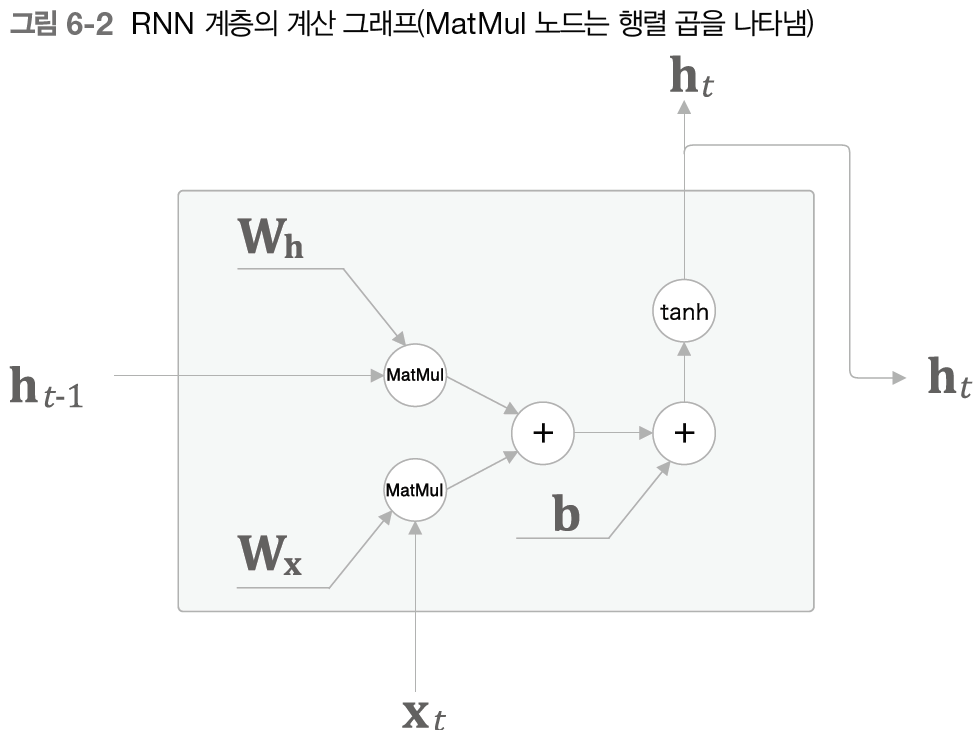

In [2]:
Image.open(os.path.join(img_path, 'fig 6-2.png'))

[그림 6-2]처럼 RNN 계층의 순전파에서 수행하는 계산은 행렬의 곱과 합, 그리고 활성화 함수인 tanh 함수에 의한 변환으로 구성된다.

이상이 앞 장에서 본 RNN 계층이다. 이어서 이러한 RNN 계층이 안고 있는 문제, 즉 장기 기억에 취약하다는 문제에 대해 알아보도록 한다.

### 6.1.2 기울기 소실 또는 기울기 폭발

언어 모델은 주어진 단어들을 기초로 다음에 출현할 단어를 예측하는 일을 한다.

앞에서는 RNN을 사용해서 언어 모델을 구현하였다(RNNLM). 이번 절에서는 RNNLM의 단점을 확인하는 차원에서 다음의 문제를 다시 한번 생각해본다.

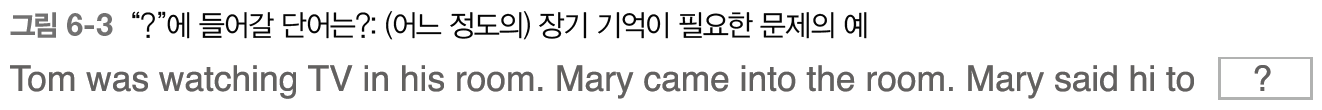

In [3]:
Image.open(os.path.join(img_path, 'fig 6-3.png'))

앞에서도 나왔듯이 "?"에 들어가는 단어는 "Tom"이다. RNNLM이 이 문제에 올바르게 답하려면, 현재 맥락에서 "Tom이 방에서 TV를 보고 있음"과 "그 방에 Mary가 들어옴"이란 정보를 기억해둬야 한다. 

다시 말해 이런 정보를 RNN 계층의 은닉 상태에 인코딩해서 보관해둬야 한다.

그럼 이 문제를 RNNLM 학습의 관점에서 생각해자. 여기에서는 정답 레이블로 "Tom"이라는 단어가 주어졌을 때, RNNLM에서 기울기가 어떻게 전파되는지를 살펴본다.

물론, 학습은 BPTT로 수행한다. 따라서 정답 레이블이 "Tom"이라고 주어진 시점으로부터 과거 방향으로 기울기를 전달하게 된다.

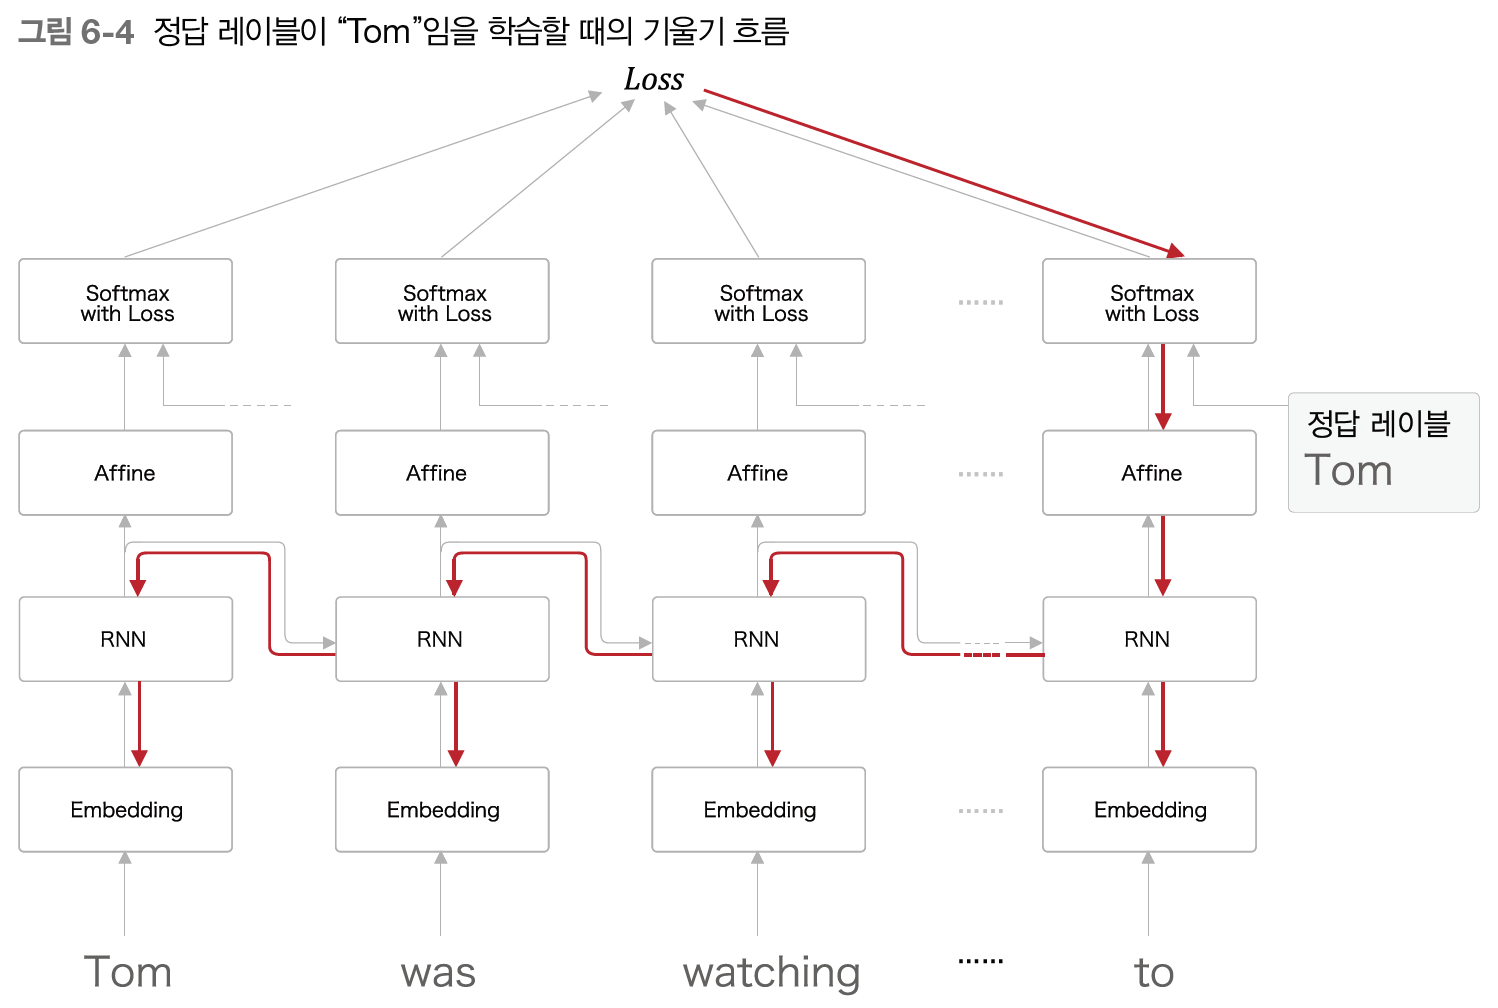

In [4]:
Image.open(os.path.join(img_path, 'fig 6-4.png'))

[그림 6-4]에서와 같이 정답 레이블이 "Tom"임을 학습할 때 중요한 것이 바로 RNN 계층의 존재이다.

RNN 계층이 과거 방향으로 '의미 있는 기울기'를 전달함으로써 시간 방향의 의존 관계를 학습할 수 있는 것이다.

이때 기울기는 (원래대로라면) 학습해야 할 의미가 있는 정보가 들어 있고, 그것을 과거로 전달함으로써 장기 의존 관계를 학습한다.

하지만 만약 이 기울기가 중간에 사그라들면(거의 아무런 정보도 남지 않게 되면) 가중치 매개변수는 전혀 갱신되지 않게 된다.

즉, 장기 의존 관계를 학습할 수 없게 된다.안타깝지만, 현재의 단순한 RNN 계층에서는 시간을 거슬러 올라갈수록

기울기가 작아지거나(기울기 소실) 혹은 커질 수 있으며(기울기 폭발), 대부분 둘 중 하나의 운명을 걷게 된다.

### 6.1.3 기울기 소실과 기울기 폭발의 원인

그럼 RNN 계층에서 기울기 소실(혹은 기울기 폭발)이 일어나는 원인을 살펴본다. [그림 6-5]와 같이 RNN 계층에서의 시간 방향 기울기 전파에만 주목해본다.

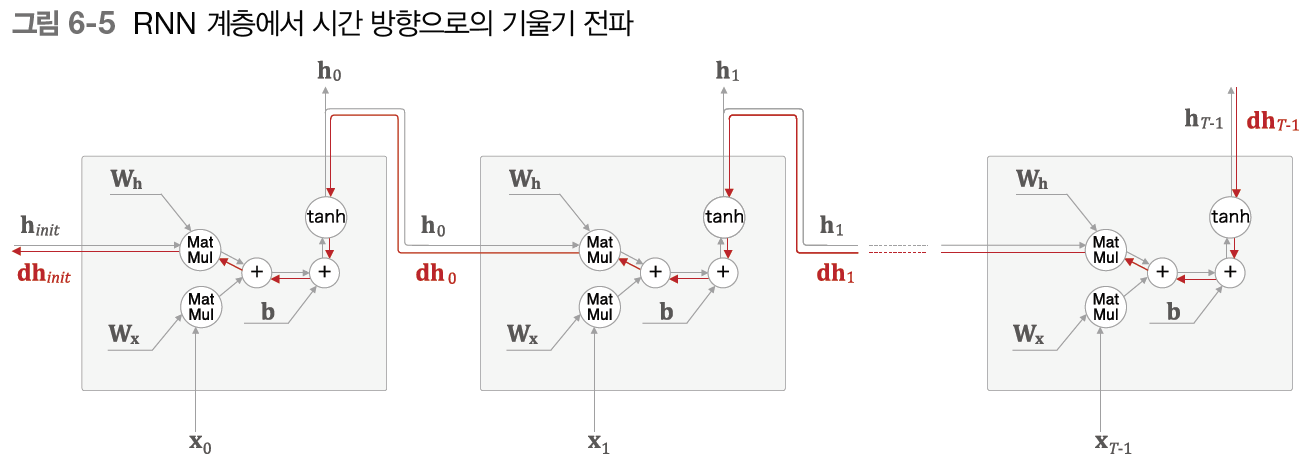

In [5]:
Image.open(os.path.join(img_path, 'fig 6-5.png'))

[그림 6-5]처럼 길이가 $T$ 인 시계열 데이터를 가정해서 $T$ 번째 정답 레이블로부터 전해지는 기울기가 어떻게 변하는지 보자.

앞의 문제에 대입하면 $T$ 번째 정답 레이블이 "Tom" 인 경우에 해당한다. 이때 시간 방향 기울기에 주목하면 역전파로 전해지는 기울기는 차례로 'tanh', '+', 'MatMul' 연산을 통과한다는 것을 알 수 있다.

'+'의 역전파는 상류에서 전해지는 기울기를 그대로 하류로 흘려보낼 뿐이다. 그래서 기울기는 변하지 않는다.

나머지 두 연산의 경우는 다르다. 우선 'tanh'부터 본다.

$y = \tanh(x)$ 일때의 미분은 $\tfrac{\partial y}{\partial x} = 1 - y^{2}$ 이다. 이때 $y = \tanh(x)$ 의 값과 그 미분 값을 각각 그래프로 그리면 다음과 같다.

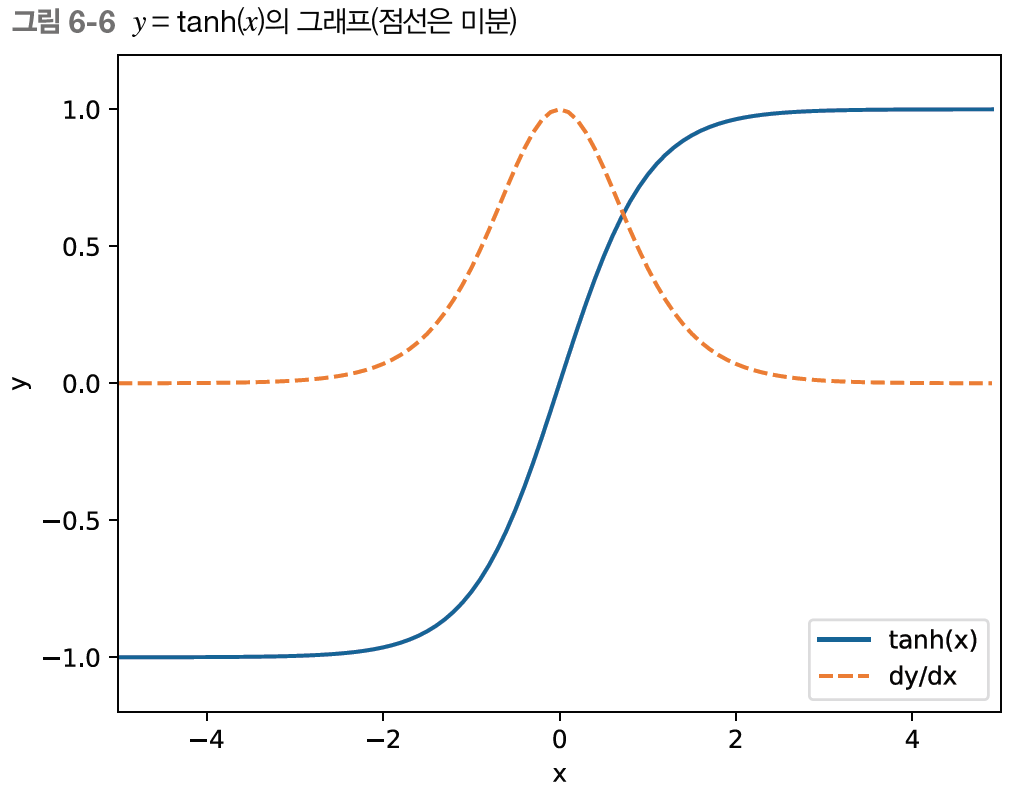

In [6]:
Image.open(os.path.join(img_path, 'fig 6-6.png'))

Text(0.5, 1.0, 'Hyperbolic Tangent Function')

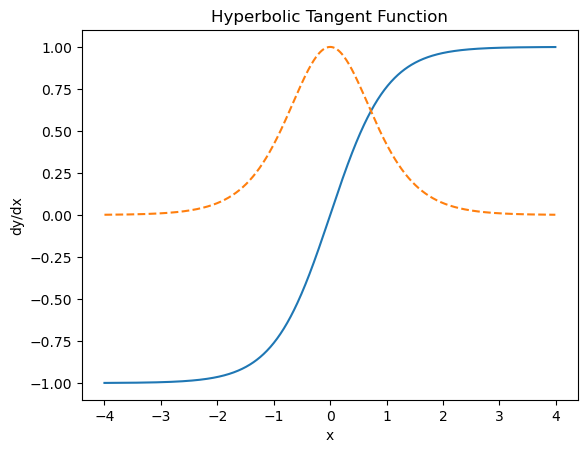

In [8]:
from matplotlib import pyplot as plt
import numpy as np

x = np.arange(-4, 4, 0.01)
y = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
y_prime = 1 - y**2


plt.plot(x, y)
plt.plot(x, y_prime, '--')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.ylabel('dy/dx')
plt.title('Hyperbolic Tangent Function')

[그림 6-6]에서 점선이 $y = \tanh(x)$ 의 미분이다. 보다시피 그 값은 1.0 이하이고, $x$ 가 0으로부터 멀어질수록 작아진다.

달리 말하면, 역전파에서는 기울기가 $\tanh$ 노드를 지날 때마다 값은 계속 작아진다는 뜻이다. 

그래서 $\tanh$ 함수를 $T$ 번 통과하면 기울기도 $T$ 번 반복해서 작아지게 된다(기울기 변화량이 점점 작아지게 되어서 학습이 잘 되지 않다는걸 말하는 듯 하다).

$\textbf{NOTE}$

RNN 계층의 활성화 함수로는 주로 tanh 함수를 사용하는데, 이를 ReLU로 바꾸면 기울기 소실을 줄일 수 있다(ReLU에 $x$ 를 입력하면 $\max (0, x)$ 를 출력한다). 그 이유는 ReLU는 입력 $x$ 가 0 이상이면, 역전파 시 상류의 기울기를 그대로 하류에 흘려보내기 때문이다. 즉 기울기가 작아지지 않는다. 실제로 [Improving performance of recurrent neural network with relu nonlinearity] 논문에서는 ReLU를 사용해서 성능을 개선했다.

다음은 [그림 6-5]의 MatMul(행렬 곱) 노드 차례이다. 여기서는 이야기를 단순하게 하기 위해 tanh 노드를 무시하기로 하자.

그러면 RNN 계층의 역전파 시 기울기는 다음 그림과 같이 'MatMul' 연산에 의해서만 변화하게 된다.

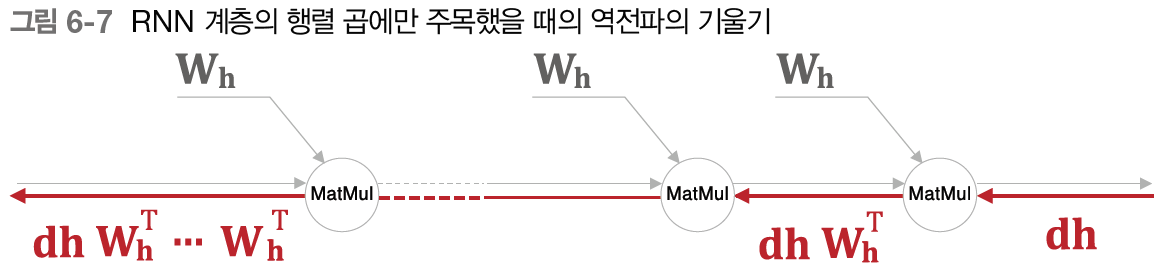

In [9]:
Image.open(os.path.join(img_path, 'fig 6-7.png'))

[그림 6-7]은 상류로부터 $\mathbf{dh}$ 라는 기울기가 흘러온다고 가정한다. 이때 MatMul 노드에서의 역전파는 $\mathbf{dh W^{\top}_{h}}$ 라는 행렬 곱으로 기울기를 계산한다.

그리고 같은 계산을 시계열 데이터의 시간 크기만큼 반복한다. 여기에서 주목할 점은 이 행렬 곱셈에서는 매번 똑같은 가중치인 $\mathbf{W_h}$ 가 사용된다는 것이다.

그러면 역전파 시 기울기는 MatMul 노드를 지날 때마다 어떻게 변화될까? 백문이 불여일견, 직접 실험해본다 (chapter06/rnn_gradient_graph.py)

이 코드에서는 `dh`를 `np.ones()`로 초기화한다. (`np.ones()` 는 모든 원소가 1인 행렬을 반환)

그리고 역전파의 MatMul 노드 수 (`T`) 만큼 `dh`를 갱신하고, 각 단계에서 `dh`크기(노름)를 `norm_list`에 추가한다.

또한 여기에서는 미니배치(`N`개)의 평균 'L2 노름'을 구해서 `dh` 크기로 사용하고 있다. 참고로, L2 노름이란 각각의 원소를 제곱해서 모두 더하고 제곱근을 취한 값이다.

코드 실행 결과는 다음과 같다.

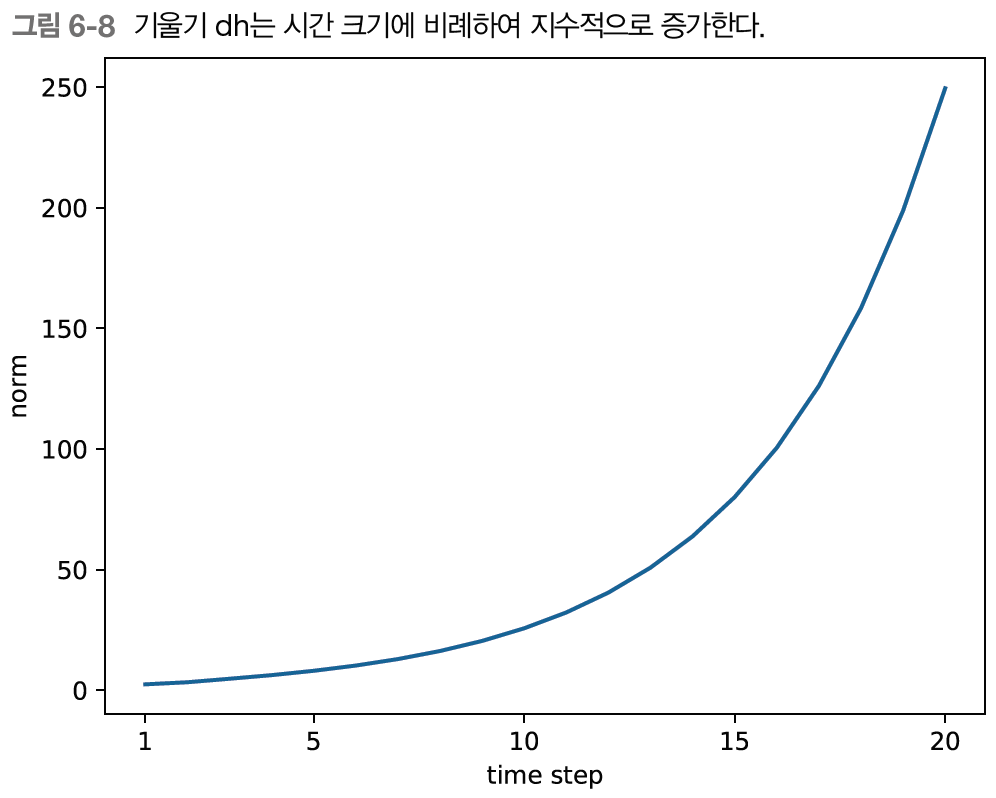

In [10]:
Image.open(os.path.join(img_path, 'fig 6-8.png'))

그림 [6-8]에서 보듯 기울기의 크기는 시간에 비례해서 지수적으로 증가함을 알 수 있다. 이것이 바로 $\textbf{기울기 폭발}^{\text{exploding gradient}}$ 이다.

이러한 기울기 폭발이 일어나면 결국 오버플로가 일어나 $\text{NaN}^{\text{Not a Number}}$ 같은 값을 발생시키게 된다.

따라서 신경망 학습을 제대로 수행할 수 없게 된다. 이어서 `Wh`의 초깃값을 다음과 같이 변경하여 두 번째 실험을 해본다.

```python
#Wh = np.random.randn(H, H)         # 변경 전
Wh = np.random.randn(H, H) * 0.5    # 변경 후
```

이 초깃값으로 실험한 결과는 다음과 같다.

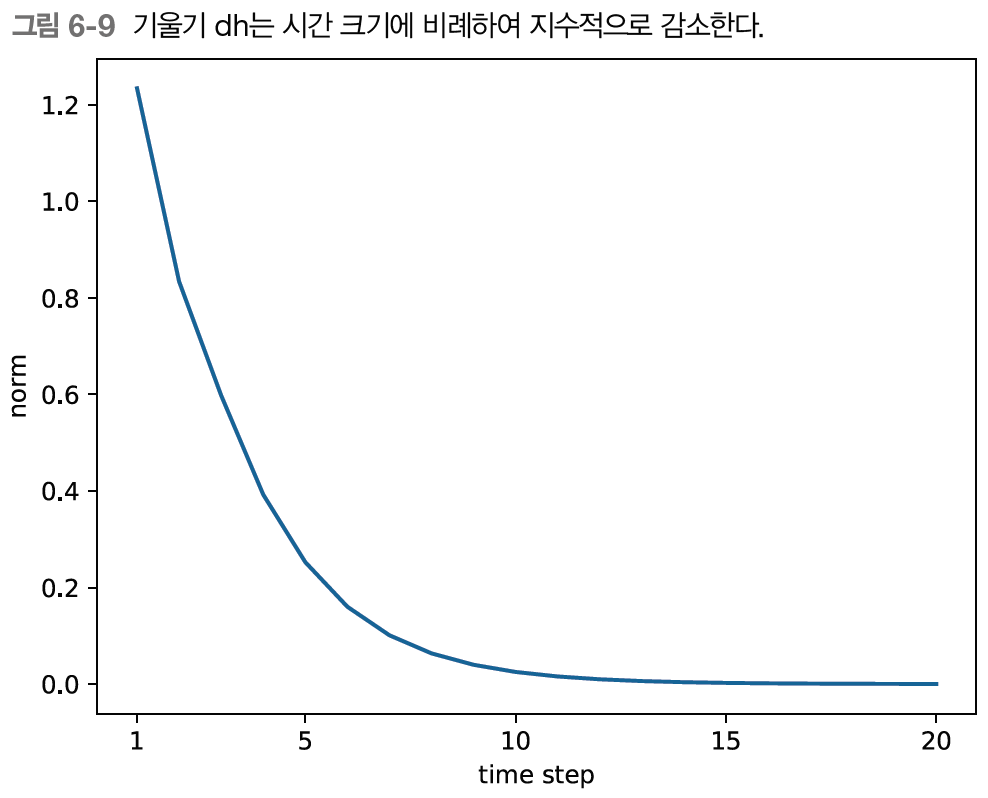

In [11]:
Image.open(os.path.join(img_path, 'fig 6-9.png'))

[그림 6-9]에서 알 수 있듯이, 이번에는 기울기가 지수적으로 감소한다. 이것이 $\textbf{기울기 소실}^{\text{vanishing gradient}}$ 이다.

기울기 소실이 일어나면 기울기가 매우 빠르게 작아진다. 그리고 기울기가 일정 수준 이하로 작아지면 가중치 매개변수가 더 이상 갱신되지 않으므로,

장기 의존 관계를 학습할 수 없게 된다.

지금까지의 실험에서 기울기의 크기는 지수적으로 증가하거나 감소했다. 왜 이런 지수적인 변화가 일어났을까?

물론 행렬 `Wh`를 `T`번 반복해서 '곱'했기 때문이다. 만약 `Wh`가 스칼라라면 이야기는 단순해지는데, `Wh`가 1보다 크면 지수적으로 증가하고, 1보다 작으면 지수적으로 감소한다.

그럼 `Wh`가 스칼라가 아니라 행렬이라면 어떨까? 이 경우, 행렬의 singular value 값이 척도가 된다. 행렬의 singular value란, 간단히 말하면 데이터가 얼마나 퍼져 있는지를 나타낸다. 

이 singular value의 값(더 정확히는 여러 singular value 중 최댓값)이 1보다 큰지 여부를 보면 기울기 크기가 어떻게 변할지 예측할 수 있다.

$\textbf{WARNING}$

특잇값의 최댓값이 1보다 크면 지수적으로 증가하고, 1보다 작으면 지수적으로 감소할 가능성이 높다고 예측할 수 있다. 그럴 가능성이 높을 뿐, 특잇값이 1보다 크다고 해서 기울기가 반드시 폭발하는 것은 아니다. 즉, 필요조건일 뿐 충분조건은 아니다. RNN의 기울기 소실/폭발에 대한 자세한 내용은 문헌[30]에 잘 나와있으니 참고한다.

### 6.1.4 기울기 폭발 대책

지금까지 RNN의 문제점(기울기 폭발과 기울기 소실)을 살펴봤다. 그럼 계속해서, 그 해결책을 알아본다. 기울기 폭발부터 보도록 하자.

기울기 폭발의 대책으로는 전통적인 기법이 존재한다. 바로 $\textbf{기울기 클리핑}^{\text{gradient clipping}}$ 이라는 기법이다.

기울기 클리핑은 매우 단순하며, 그 알고리즘을 의사 코드로 쓰면 다음과 같다.

\begin{align*}
    \text{if} \quad &  ||\hat{g}|| \geq \text{threshold} : \\
    \quad \quad \hat{g} &  = \cfrac{\text{threshold}}{||\hat{g}||} \hat{g}
\end{align*}

여기에서는 신경망에서 사용되는 모든 매개변수에 대한 기울기를 하나로 처리한다고 가정하고, 이를 기호 $\hat{g}$ 로 표기했다. 

그리고 $\text{threshold}$ 를 문턱값으로 설정한다. 이때 기울기의 L2 노름(수식에서는 $||\hat{g}|||$) 이 문턱값을 초과하면 두 번째 줄의 수식과 같이 기울기를 수정한다.

이것이 기울기 클리핑이다. 보다시피 단순한 알고리즘이지만, 많은 경우에 잘 작동한다.


$\textbf{WARNING}$

$\hat{g}$ 는 신경망에서 사용되는 모든 매개변수의 기울기를 하나로 모은 것이다. 예컨대 두 개의 가중치 W1과 W2 매개변수를 사용하는 모델이 있다면, 이 두 매개변수에 대한 기울기 dW1과 dW2를 결합한 것을 $\hat{g}$ 라고 하는 것이다.

이제 기울기 클리핑을 파이썬으로 구현해본다. 기울기 클리핑은 `clip_grads(grads, max_norm)`이라는 함수로 구현한다.

인수 `grads`는 기울기의 리스트, `max_norm`은 문턱값을 뜻한다. (chapter06/clip_grads.py)

이것이 기울기 클리핑의 구현이다. 이 `clip_grads(grads, max_norm)` 함수는 앞으로도 이용하므로 common/util.py에 같은 구현을 한다.

## 6.2 기울기 소실과 LSTM